In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import data_handler as dh
import unfolding_noML as uf
hep.style.use(hep.style.CMS)

## Creating fake data for testing

In [2]:
smearing_function = "smear"
if smearing_function == "calo":
    sim_bins = 40
    MC_bins = 40
    sim_low = 0
    sim_high = 10
    MC_low = 0
    MC_high = 10
else:
    sim_bins = 40
    MC_bins = 40
    sim_low = -10
    sim_high = 10
    MC_low = -10
    MC_high = 10

In [3]:
f0 = ROOT.TH1D("f0","f0",MC_bins,MC_low,MC_high)
g0 = ROOT.TH1D("g0","g0",sim_bins,sim_low,sim_high)
response = ROOT.RooUnfoldResponse (sim_bins, sim_low, sim_high, MC_bins, MC_low, MC_high)

In [4]:
n_data_points = 100000
sim_data = []
MC_data = []

In [5]:
for i in range(n_data_points):
  if smearing_function == "calo":
      xt = ROOT.gRandom.BreitWigner(5.0, 1.0)
  else:
      xt = ROOT.gRandom.BreitWigner(0.3, 2.5)
  f0.Fill(xt)
  x = dh.smearing_wrapper(xt, smearing_function)
  fill_MC = False
  if xt > MC_low and xt < MC_high:
      MC_data.append(xt)
      fill_MC = True
  if x!=None:
    response.Fill(x, xt)
    g0.Fill(x)
    if x > sim_low and x < sim_high:
        if not fill_MC:
            MC_data.append(np.nan)
        sim_data.append(x)
    else:
        if fill_MC:
            sim_data.append(np.nan)
  else:
    response.Miss(xt)
    if fill_MC:
        sim_data.append(np.nan)
sim_data = np.array(sim_data, dtype=np.float64)
MC_data = np.array(MC_data, dtype=np.float64)

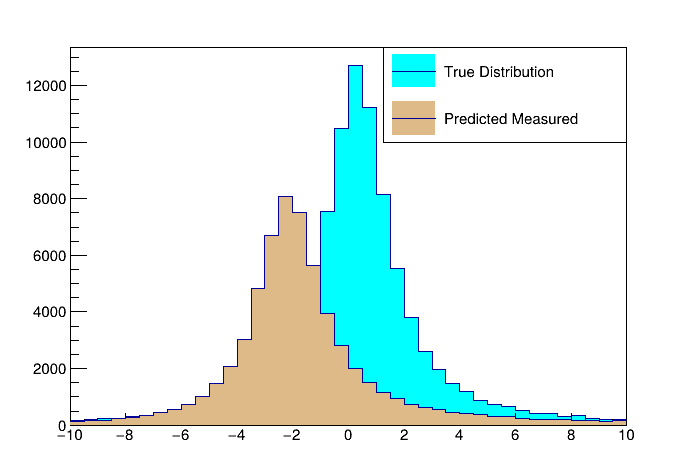

In [6]:
c = ROOT.TCanvas()
f0.SetStats(0)
f0.SetTitle("")
f0.SetFillColor(7)
f0.Draw()
g0.SetFillColor(42)
g0.Draw("same")
leg = ROOT.TLegend(.55,0.7,.9,.9)
leg.AddEntry(f0,"True Distribution")
leg.AddEntry(g0,"Predicted Measured")
leg.Draw()
c.Draw()

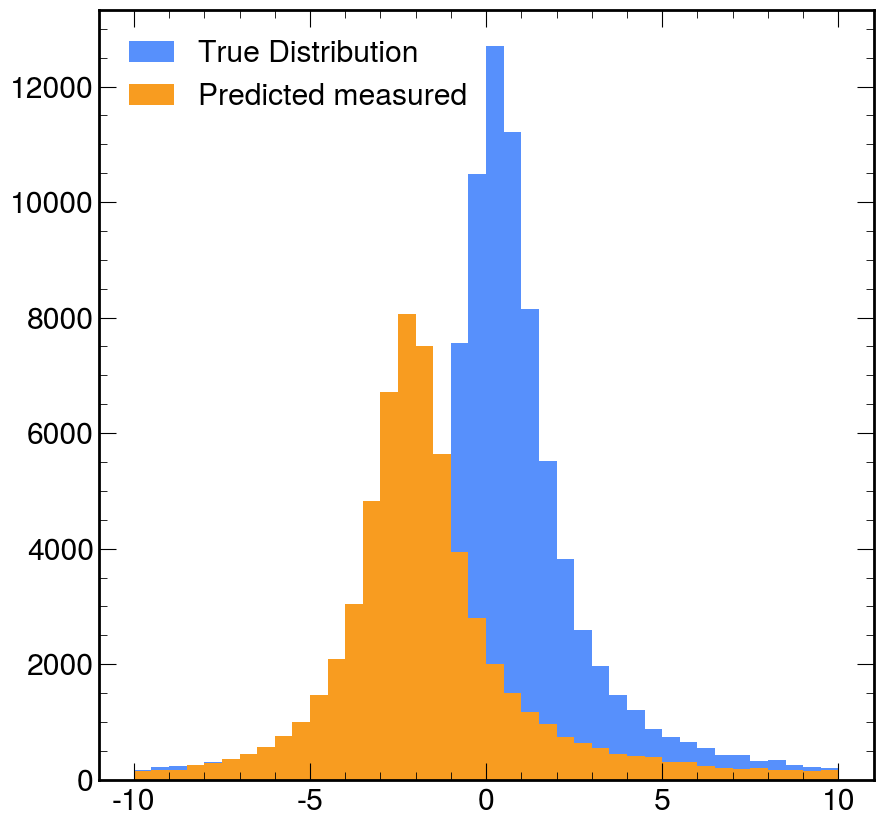

In [7]:
plt.hist(MC_data, bins = MC_bins, range=(MC_low,MC_high), label='True Distribution')
plt.hist(sim_data, bins = sim_bins, range=(sim_low,sim_high), label='Predicted measured')
plt.legend()

In [8]:
hTrue = ROOT.TH1D ("true", "Test Truth",    MC_bins, MC_low, MC_high);
hMeas = ROOT.TH1D ("meas", "Test Measured", sim_bins, sim_low, sim_high);
#  Test with a Gaussian, mean 0 and width 2.                                                                                          
for i in range(10000):
    if smearing_function == "calo":
        xt = ROOT.gRandom.Gaus (5.0, 1.0)
    else:
        xt = ROOT.gRandom.Gaus (0.0, 2.0)
    x = dh.smearing_wrapper(xt, smearing_function);
    hTrue.Fill(xt);
    if x != None: hMeas.Fill(x);

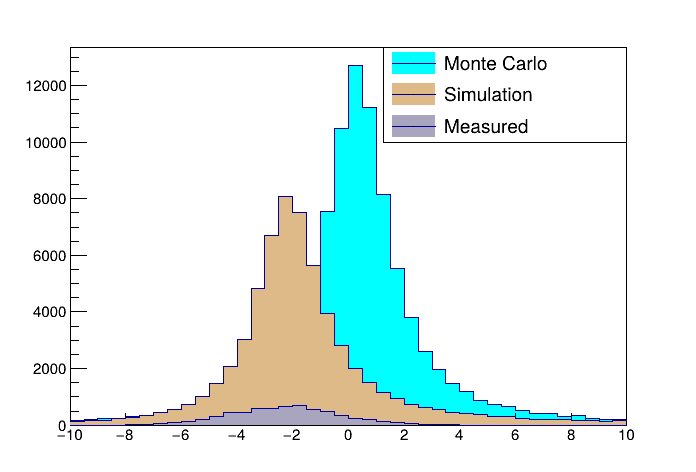

In [9]:
c = ROOT.TCanvas()
f0.SetStats(0)
f0.SetTitle("")
f0.SetFillColor(7)
f0.Draw()
g0.SetFillColor(42)
g0.Draw("same")
hMeas.Draw("same")
hMeas.SetFillColor(40)
leg = ROOT.TLegend(.55,0.7,.9,.9)
leg.AddEntry(f0,"Monte Carlo")
leg.AddEntry(g0,"Simulation")
leg.AddEntry(hMeas, "Measured")
leg.Draw()
c.Draw()

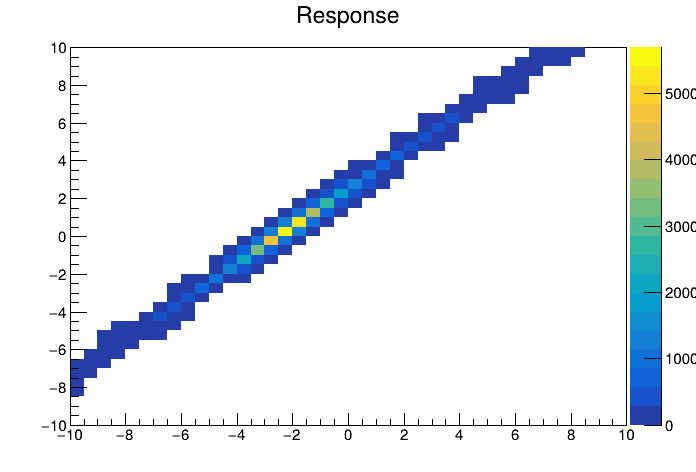

In [10]:
R = response.HresponseNoOverflow()
c1 = ROOT.TCanvas()
R.SetStats(0)
R.Draw("colz")
c1.Draw()

## Results using RooUnfold's IBU method

In [11]:
num_iterations = 4

In [12]:
IBU_RooUnfold = ROOT.RooUnfoldBayes(response, hMeas, num_iterations)
hReco_RooUnfold = IBU_RooUnfold.Hunfold()

Using response matrix priors
Priors:

Vector (40)  is as follows

     |        1  |
------------------
   0 |0.00182442 
   1 |0.00239998 
   2 |0.00254116 
   3 |0.00255202 
   4 |0.00327961 
   5 |0.00362712 
   6 |0.00423526 
   7 |0.00485426 
   8 |0.00548412 
   9 |0.00658095 
  10 |0.00825333 
  11 |0.00953477 
  12 |0.0113158 
  13 |0.0149103 
  14 |0.0202641 
  15 |0.0282785 
  16 |0.0373029 
  17 |0.0542874 
  18 |0.082099 
  19 |0.113874 
  20 |0.137874 
  21 |0.121704 
  22 |0.088441 
  23 |0.059967 
  24 |0.0414947 
  25 |0.0282025 
  26 |0.0214044 
  27 |0.0160071 
  28 |0.013075 
  29 |0.00951305 
  30 |0.00807958 
  31 |0.00709135 
  32 |0.00586421 
  33 |0.00466965 
  34 |0.00455019 
  35 |0.00356197 
  36 |0.00362712 
  37 |0.00276921 
  38 |0.0023674 
  39 |0.00223709 

Now unfolding...
Iteration : 0
Chi^2 of change 970.321
Iteration : 1
Chi^2 of change 7.84678
Iteration : 2
Chi^2 of change 1.56566
Iteration : 3
Chi^2 of change 0.843821
Calculating covariances due to

In [13]:
t_distributions = uf.manual_IBU_np(sim_data, MC_data, sim_bins, MC_bins, sim_low, sim_high, MC_low, MC_high, hMeas, num_iterations)

Iteration 0
Iteration 1
Iteration 2
Iteration 3


In [14]:
nu_distributions, omega_distributions = uf.no_ml_omnifold_np(sim_data, MC_data, sim_bins, MC_bins, sim_low, sim_high, MC_low, MC_high, hMeas, num_iterations)

Iteration 0
Iteration 1
Iteration 2
Iteration 3


In [15]:
miss_mask = (~np.isnan(sim_data)) & (~np.isnan(MC_data))
MC_hist = np.histogram(MC_data[~np.isnan(MC_data)], bins = MC_bins, range = [MC_low, MC_high])[0]
sim_hist = np.histogram(sim_data[~np.isnan(sim_data)], bins = sim_bins, range = [sim_low, sim_high])[0]

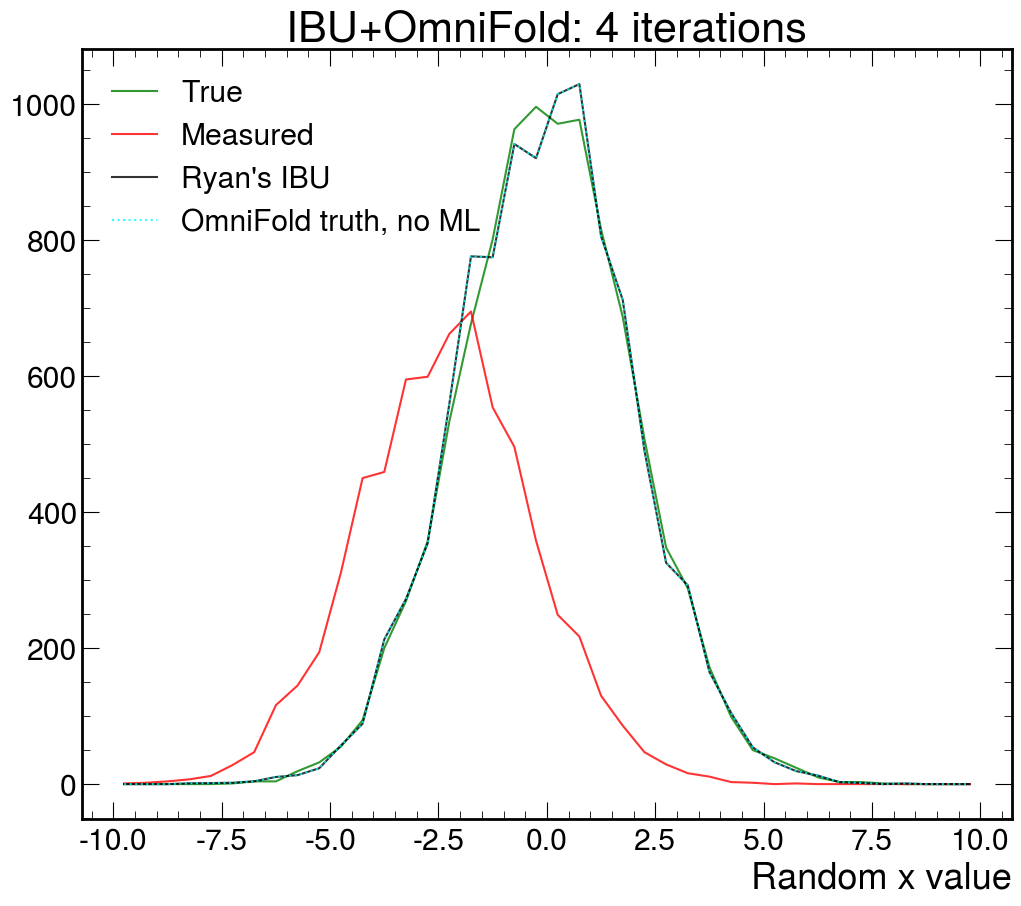

In [16]:
true_data, true_x = dh.TH1_to_numpy(hTrue)
roounfold_data, roounfold_x = dh.TH1_to_numpy(hReco_RooUnfold)
measured_data, measured_x = dh.TH1_to_numpy(hMeas)

fig = plt.figure(figsize=(12,10))
plt.plot(true_x, true_data, label = "True", color = 'green', alpha = .8)
plt.plot(measured_x, measured_data, label = "Measured", color = 'red', alpha = .8)

# plt.plot(roounfold_x, roounfold_data, label = "RooUnfold", linestyle='dashed', alpha = .8)
plt.plot(true_x, t_distributions[-1], label = "Ryan's IBU", linestyle = 'solid', alpha = .8, color = 'black')
plt.plot(true_x, MC_hist*nu_distributions[-1], label = "OmniFold truth, no ML", linestyle='dotted', alpha = .8, color = 'cyan')

plt.xlabel("Random x value")
plt.title(f"IBU+OmniFold: {num_iterations} iterations")
plt.legend()
# plt.grid()
plt.show()

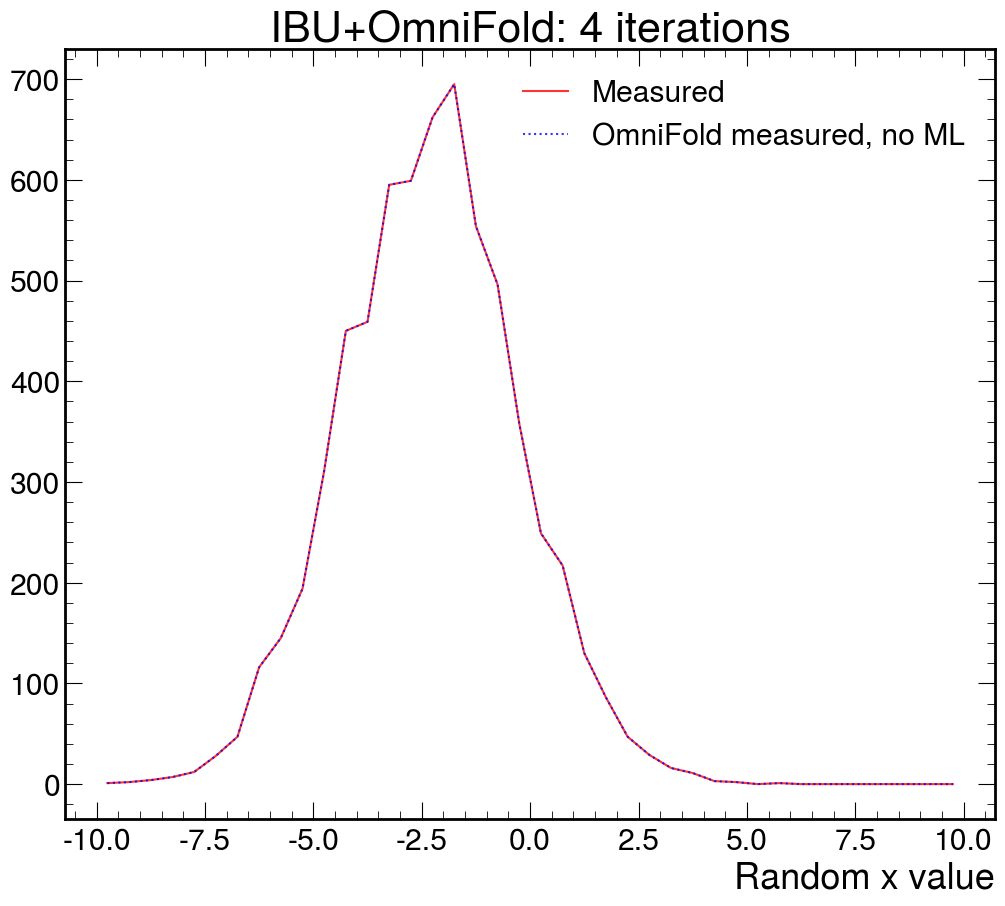

In [17]:
measured_data, measured_x = dh.TH1_to_numpy(hMeas)

fig = plt.figure(figsize=(12,10))
plt.plot(measured_x, measured_data, label = "Measured", linestyle = 'solid', alpha = .8, color = 'red')
plt.plot(true_x, sim_hist*omega_distributions[0], label = "OmniFold measured, no ML", linestyle='dotted', alpha = .8, color = 'blue')

plt.xlabel("Random x value")
plt.title(f"IBU+OmniFold: {num_iterations} iterations")
plt.legend()
# plt.grid()
plt.show()

In [18]:
unfolded_ROOT = uf.manual_IBU_ROOT(response, hMeas, num_iterations)

Iteration 0
Iteration 1
Iteration 2
Iteration 3


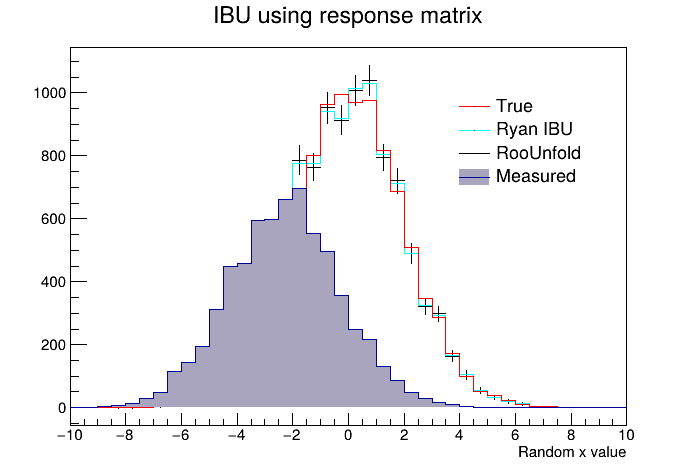

In [19]:
c1 = ROOT.TCanvas()
hReco_RooUnfold.SetStats(0)
hReco_RooUnfold.SetTitle("IBU using response matrix")
hReco_RooUnfold.SetLineColor(1)
hTrue.SetLineColor(2)
hReco_RooUnfold.Draw()
unfolded_ROOT.Draw("same")
hTrue.Draw("same")
hMeas.Draw("same")
unfolded_ROOT.SetLineColor(7)
leg = ROOT.TLegend(0.65, 0.6, 0.9, 0.8)
leg.AddEntry(hTrue, "True","pl")
leg.AddEntry(unfolded_ROOT, "Ryan IBU")
leg.AddEntry(hReco_RooUnfold, "RooUnfold")
leg.AddEntry(hMeas, "Measured")
leg.SetBorderSize(0)
leg.Draw()
hReco_RooUnfold.GetXaxis().SetTitle("Random x value")
c1.Draw()